In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm

# Introduction

In this notebook, I do some analysis - mostly brief, exploratory analysis - of my liked songs on Spotify. This project is purely driven by personal interest, with no pretensions of practical use. I like music as much as the next person, so when I learned that Spotify attempted to quantify various characteristics of music and automatically detect others, I became interested in what I could learn about my own taste, other than I like songs that are mostly metal, some mixture between corny and aggressive, and loud. To do this, I performed a clustering analysis.

In [3]:
df = pd.read_csv('liked_songs.csv', index_col=0)
print(f'There are {len(df)} rows in the dataframe.')
df.head()

There are 1336 rows in the dataframe.


id                                         track_name  \
0  2mkIuDdISUvCcrxxZ4EN6b                                  Edge of the Night   
1  0DDUNKcxiNVf7mMhGovPT0                                       Kronian Moon   
2  4oTLgIDkeBPB4YjHRGJ6EI                                      Glitch Cannon   
3  2Pvxvrbl8J6YFl5vSJzEDp                                      Discipline 27   
4  0BUxtt8OufQRdqpcu2uaXU  The Lady with the Golden Stockings (The Golden...   

             artist                  album_name album_release_date  \
0              Nite  Voices of the Kronian Moon         2022-03-25   
1              Nite  Voices of the Kronian Moon         2022-03-25   
2  Artificial Brain            Artificial Brain         2022-06-03   
3              EABS        Discipline of Sun Ra         2020-10-30   
4              EABS        Discipline of Sun Ra         2020-10-30   

   album_track_num  album_track_placement  genre  duration_ms  explicit  ...  \
0                6               0.750000    NaN     5.057467     False  ...   
1                2               0.250000    NaN     3.989900     False  ...   
2                2               0.200000    NaN     3.635300     False  ...   
3                4               0.571429    NaN     5.344567     False  ...   
4                3               0.428571    NaN     3.306467     False  ...   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    9    -5.673     0       0.1450      0.000010             0.777     0.122   
1    2    -4.680     0       0.0578      0.000018             0.516     0.106   
2    5    -9.562     0       0.0614      0.000124             0.945     0.436   
3   10    -8.203     0       0.0501      0.043400             0.336     0.278   
4   11    -9.357     0       0.0564      0.193000             0.944     0.118   

   valence    tempo  time_signature  
0   0.1700  144.036               4  
1   0.1670  123.982               4  
2   0.0363   95.020               4  
3   0.2050   90.492               4  
4   0.1850  117.210               3  

[5 rows x 23 columns]

# Data Cleaning

## Checking the Genre Feature
According to Spotify's API documentation, when looking up track info, the response should either contain an array of genres for the tracks artist, which should be empty if no genres are assigned. This does not seem to actually be the case at least for every artist, and when running a few google searches, I found people who had similar issues over the past several years. I wrote my code to save genre information to a csv if present and enter a NaN value otherwise. Here, I check to see if there was any genre information. If there is not, I drop the feature.

In [4]:
df['genre'].unique()[0]

nan

In [5]:
if len(df['genre'].unique()) == 1:
    genre_val = df['genre'].unique()[0]
    print(f'The genre field contains only the following value: {genre_val}.')
    df = df.drop('genre', axis=1)
else:
    print('The genre feature contains non-nan values.')

The genre field contains only the following value: nan.


## Encoding Album Release Dates
Spotify does not always have exact release dates. Sometimes it has release years. For consistency and cleanliness, I will keep only release years for all albums. Values are either in YYYY-MM-DD format or are just the years, so to get years, I split on dashes, and keep only the first entry in the resulting list.

In [6]:
df['album_release_date'] = df['album_release_date'].str.split('-').map(lambda x: int(x[0]))

## Renaming Columns
I rename album_release_date to album_release_year because of the above change. Additionally, I rename duration_ms to duration_min, since the units are minutes.

In [7]:
df = df.rename(columns={'album_release_date':'album_release_year', 'duration_ms':'duration_min'})

# Exploratory Data Analysis

In [8]:
numerical = ['album_track_num', 'album_track_placement', 'album_release_year', 'duration_min', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
boolean = ['mode', 'explicit']
categorical = ['artist_name', 'album_name']
song_info = ['track_name', 'artist', 'album_name']
df[numerical].describe()

album_track_num  album_track_placement  album_release_year  \
count      1336.000000            1336.000000         1336.000000   
mean          4.155689               0.433919         2010.854790   
std           2.955300               0.278496            7.549776   
min           1.000000               0.030303         1972.000000   
25%           2.000000               0.200000         2008.000000   
50%           3.000000               0.375000         2013.000000   
75%           6.000000               0.625000         2016.000000   
max          16.000000               1.000000         2022.000000   

       duration_min   popularity  danceability       energy          key  \
count   1336.000000  1336.000000   1336.000000  1336.000000  1336.000000   
mean       6.186966    13.269461      0.337626     0.825712     5.208832   
std        3.615311    15.025945      0.144844     0.199650     3.588865   
min        0.968217     0.000000      0.059300     0.000707     0.000000   
25%        4.203025     0.000000      0.217000     0.762750     2.000000   
50%        5.304775     9.000000      0.336500     0.908000     5.000000   
75%        7.189333    23.000000      0.443250     0.961000     8.000000   
max       57.003767    73.000000      0.903000     0.999000    11.000000   

          loudness  speechiness  acousticness  instrumentalness     liveness  \
count  1336.000000  1336.000000   1336.000000       1336.000000  1336.000000   
mean     -6.565744     0.085956      0.054443          0.435847     0.223005   
std       3.450206     0.060603      0.173401          0.372322     0.166793   
min     -42.238000     0.024900      0.000000          0.000000     0.020400   
25%      -7.747250     0.046100      0.000020          0.012175     0.104000   
50%      -5.793500     0.068800      0.000220          0.460500     0.156000   
75%      -4.532750     0.103000      0.005097          0.816250     0.313250   
max       2.121000     0.798000      0.985000          0.995000     0.970000   

           valence        tempo  time_signature  
count  1336.000000  1336.000000     1336.000000  
mean      0.211099   123.759373        3.815120  
std       0.166339    29.276529        0.540034  
min       0.021500    56.542000        1.000000  
25%       0.079875   102.066500        4.000000  
50%       0.162000   120.035500        4.000000  
75%       0.300000   143.386000        4.000000  
max       0.964000   200.188000        5.000000

In [9]:
for feat in numerical[2:]:
    print(f'________________________{feat.upper()}________________________')
    min_feat_values = df[df[feat] == df[feat].min()][song_info+[feat]].values[0]
    max_feat_values = df[df[feat] == df[feat].max()][song_info+[feat]].values[0]
    print(f'The song with the highest {feat} is {max_feat_values[0]} by {max_feat_values[1]} off of the album {max_feat_values[2]}, with a {feat} value of {max_feat_values[3]}')
    print(f'The song with the lowest {feat} is {min_feat_values[0]} by {min_feat_values[1]} off of the album {min_feat_values[2]}, with a {feat} value of {min_feat_values[3]}\n')

________________________ALBUM_RELEASE_YEAR________________________
The song with the highest album_release_year is Edge of the Night by Nite off of the album Voices of the Kronian Moon, with a album_release_year value of 2022
The song with the lowest album_release_year is Suicide by Dust off of the album Hard Attack/Dust, with a album_release_year value of 1972

________________________DURATION_MIN________________________
The song with the highest duration_min is Monolithe IV by Monolithe off of the album Monolithe IV, with a duration_min value of 57.00376666666667
The song with the lowest duration_min is I Accept Your Last Wish by Gridlink off of the album Orphan, with a duration_min value of 0.9682166666666668

________________________POPULARITY________________________
The song with the highest popularity is C.R.E.A.M. (Cash Rules Everything Around Me) (feat. Method Man, Raekwon, Inspectah Deck & Buddha Monk) by Wu-Tang Clan off of the album Enter The Wu-Tang (36 Chambers) [Expanded 

Most of the above are very sensible, with the exception of a few values that suggest errors on Spotify's end. For brevity, I will only discuss potential errors.

Sepal by Emptyset is purely instrumental, but Spotify is fairly confident it is largely speech. The song seems to largely consist of a recording of a person playing a wind or reed instrument, including the sound of the breath, edited in various ways.

Spotify seems to have struggled with Edeste by Khôrada, finding its modality to be major and its time signature presumably to be 1/4. While my music theory is rusty, the song to be is not so obviously major. Further, Spotify's [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) states they give songs time signature values ranging from 3 to 7, corresponding to 3/4, 4/4, 5/4, 6/4 and 7/4, but they gave this song a 1. It is unclear why this is the case. The song is in 6/8, but there are some drony sections that might confuse a computer trying to assign the song a time signature.

I suspect the time_signature identification might be unreliable. In addition to the above, I know I have a song in my liked songs that is 7/4, Foe by the band Leprous, but I have no songs with time_signature = 7. First, I check what time signature that song was assigned.

In [10]:
df[df['track_name'] == 'Foe'][song_info+['time_signature']]

track_name   artist album_name  time_signature
918        Foe  Leprous       Coal               1

Similarly to Edeste, this song has a time_signature value of 1. And the percussion in this [song](https://www.youtube.com/watch?v=D61fSxqBLwc) makes the time signature a bit non-obvious, even to a human listener. This makes me think that maybe time_signature values of 1 are assigned if the time signature is unknown. I peak at the songs with time_signature = 1 to find out more.

In [11]:
time_sig_1 = df[df['time_signature'] == 1]
print(f'There are {len(time_sig_1)} songs with a time_signature value of 1')
time_sig_1[song_info]

There are 23 songs with a time_signature value of 1


track_name                   artist  \
5                                         Edeste                  Khôrada   
136   Into the Vaults of Ingurgitating Obscurity              Chthe'ilist   
171              Shake My Hand, Bow down and Die              Die Choking   
187                                      Motions     Sun Of The Sleepless   
272                      Within the Dead Horizon                   Inferi   
286                 Self Portrait In Ultramarine                Ben Frost   
315                                         Shed                Meshuggah   
321                                   Clockworks                Meshuggah   
326                         Where Mountains Rise                 Immortal   
360        What a Horrible Night to Have a Curse  The Black Dahlia Murder   
483                                The Architect                    Haken   
484                                         1985                    Haken   
627                                  In Memoriam                    Haken   
704                                        Again     Black Crown Initiate   
743                                   Clockworks                Meshuggah   
862                       Body Bags for the Gods                Katalepsy   
918                                          Foe                  Leprous   
928                                The Architect                    Haken   
929                                         1985                    Haken   
959                      And the Vulture Beholds      Fleshgod Apocalypse   
1103                        Closed Gates Of Hope                Catamenia   
1189                           March Of The Pigs          Nine Inch Nails   
1267                                 In Memoriam                    Haken   

                                 album_name  
5                                      Salt  
136                   Le Dernier Crépuscule  
171                                     III  
187                         To the Elements  
272                                Revenant  
286   All That You Love Will Be Eviscerated  
315                      Catch Thirty Three  
321             The Violent Sleep of Reason  
326                     Northern Chaos Gods  
360                               Nocturnal  
483                                Affinity  
484                                Affinity  
627                            The Mountain  
704                Selves We Cannot Forgive  
743             The Violent Sleep of Reason  
862                           Autopsychosis  
918                                    Coal  
928               Affinity (Deluxe Edition)  
929               Affinity (Deluxe Edition)  
959                                    King  
1103                         Location: COLD  
1189                    The Downward Spiral  
1267                           The Mountain

Self Portrait in Ultramarine is drony and noisy, with no discernible time signature. March of the Pigs is in multiple time signatures, one of which is 7/8 according to a google search.

# Univariate Distributions

In [12]:
df.describe()

album_release_year  album_track_num  album_track_placement  \
count         1336.000000      1336.000000            1336.000000   
mean          2010.854790         4.155689               0.433919   
std              7.549776         2.955300               0.278496   
min           1972.000000         1.000000               0.030303   
25%           2008.000000         2.000000               0.200000   
50%           2013.000000         3.000000               0.375000   
75%           2016.000000         6.000000               0.625000   
max           2022.000000        16.000000               1.000000   

       duration_min   popularity  danceability       energy          key  \
count   1336.000000  1336.000000   1336.000000  1336.000000  1336.000000   
mean       6.186966    13.269461      0.337626     0.825712     5.208832   
std        3.615311    15.025945      0.144844     0.199650     3.588865   
min        0.968217     0.000000      0.059300     0.000707     0.000000   
25%        4.203025     0.000000      0.217000     0.762750     2.000000   
50%        5.304775     9.000000      0.336500     0.908000     5.000000   
75%        7.189333    23.000000      0.443250     0.961000     8.000000   
max       57.003767    73.000000      0.903000     0.999000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  1336.000000  1336.000000  1336.000000   1336.000000       1336.000000   
mean     -6.565744     0.566617     0.085956      0.054443          0.435847   
std       3.450206     0.495728     0.060603      0.173401          0.372322   
min     -42.238000     0.000000     0.024900      0.000000          0.000000   
25%      -7.747250     0.000000     0.046100      0.000020          0.012175   
50%      -5.793500     1.000000     0.068800      0.000220          0.460500   
75%      -4.532750     1.000000     0.103000      0.005097          0.816250   
max       2.121000     1.000000     0.798000      0.985000          0.995000   

          liveness      valence        tempo  time_signature  
count  1336.000000  1336.000000  1336.000000     1336.000000  
mean      0.223005     0.211099   123.759373        3.815120  
std       0.166793     0.166339    29.276529        0.540034  
min       0.020400     0.021500    56.542000        1.000000  
25%       0.104000     0.079875   102.066500        4.000000  
50%       0.156000     0.162000   120.035500        4.000000  
75%       0.313250     0.300000   143.386000        4.000000  
max       0.970000     0.964000   200.188000        5.000000

## Numerical Features

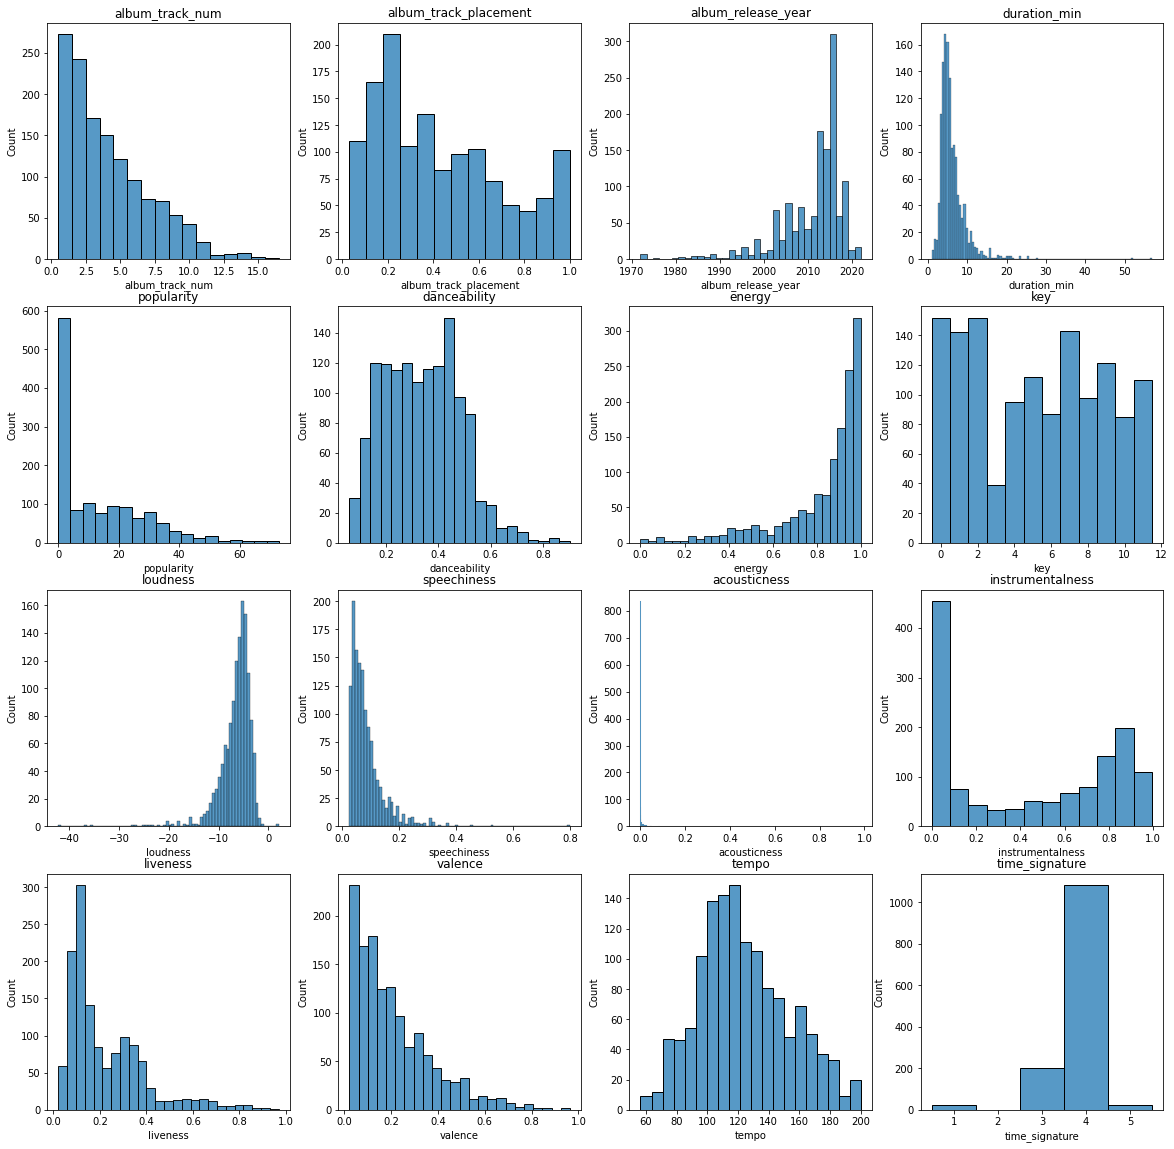

In [140]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, discrete=True, ax=ax)
    else:
        sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)

## Boolean Features

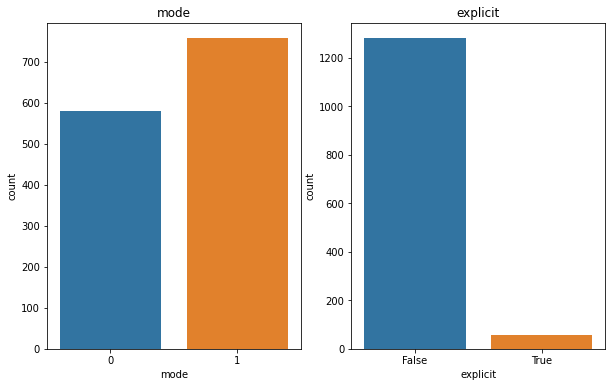

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

for col, ax in zip(boolean, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)

I am skeptical of both of these. The mode feature represents whether songs are major (1) or minor (0). The plot above suggests most of the songs I've liked have been major. While not impossible, I listen to a lot of metal, which makes the plot unlikely. The second plot is likely misleading. Spotify uses the False value in its explicit feature for songs if it does not know whether lyrics are explicit. Again, I listen to a good bit of metal, so it's highly likely that I've liked a lot songs with unpublished lyrics.

## Other Categorical Features

In [15]:
num_unique_bands = len(df['artist'].unique())
num_unique_albums = len(df['album_name'].unique())
print(f'There are {num_unique_albums} albums by {num_unique_bands} bands.')

There are 666 albums by 434 bands.


In [16]:
print('Top 5 most liked artists:')
df['artist'].value_counts().head(5)

Top 5 most liked artists:


Agent Fresco           23
Sonata Arctica         22
Mors Principium Est    21
Meshuggah              18
GALNERYUS              16
Name: artist, dtype: int64

In [17]:
print('Top 5 most liked albums:')
df['album_name'].value_counts().head(5)

Top 5 most liked albums:


Pariah's Child           14
Songs For The Deaf       14
Destrier                 14
The Tides of Damocles    10
Dawn of the 5TH Era       9
Name: album_name, dtype: int64

I list only the top five for each since something immediately popped out at me - the bands with songs I like most frequently and albums with songs I like most frequently are not comprised mostly of bands or albums I remember liking much, or sometimes at all. On closer inspection, what seems to have happened is that I liked entire albums, which I know is something I've done so I don't forget to get around to listening to an album. This makes it look like I like all of the tracks on the album and inflates the number of songs by the band that I've liked. Combine this with the relatively large number of unique artists and bands, and I do not think there is much useful information in these features.

Since I can confidently state I listen to mostly metal, I would hazard a guess that I listen to bands mostly from a fairly small subset of European countries. If I continue this project in the future, I may find the country of origin for bands to be a more useful feature.

# Bivariate Analysis

<AxesSubplot:>

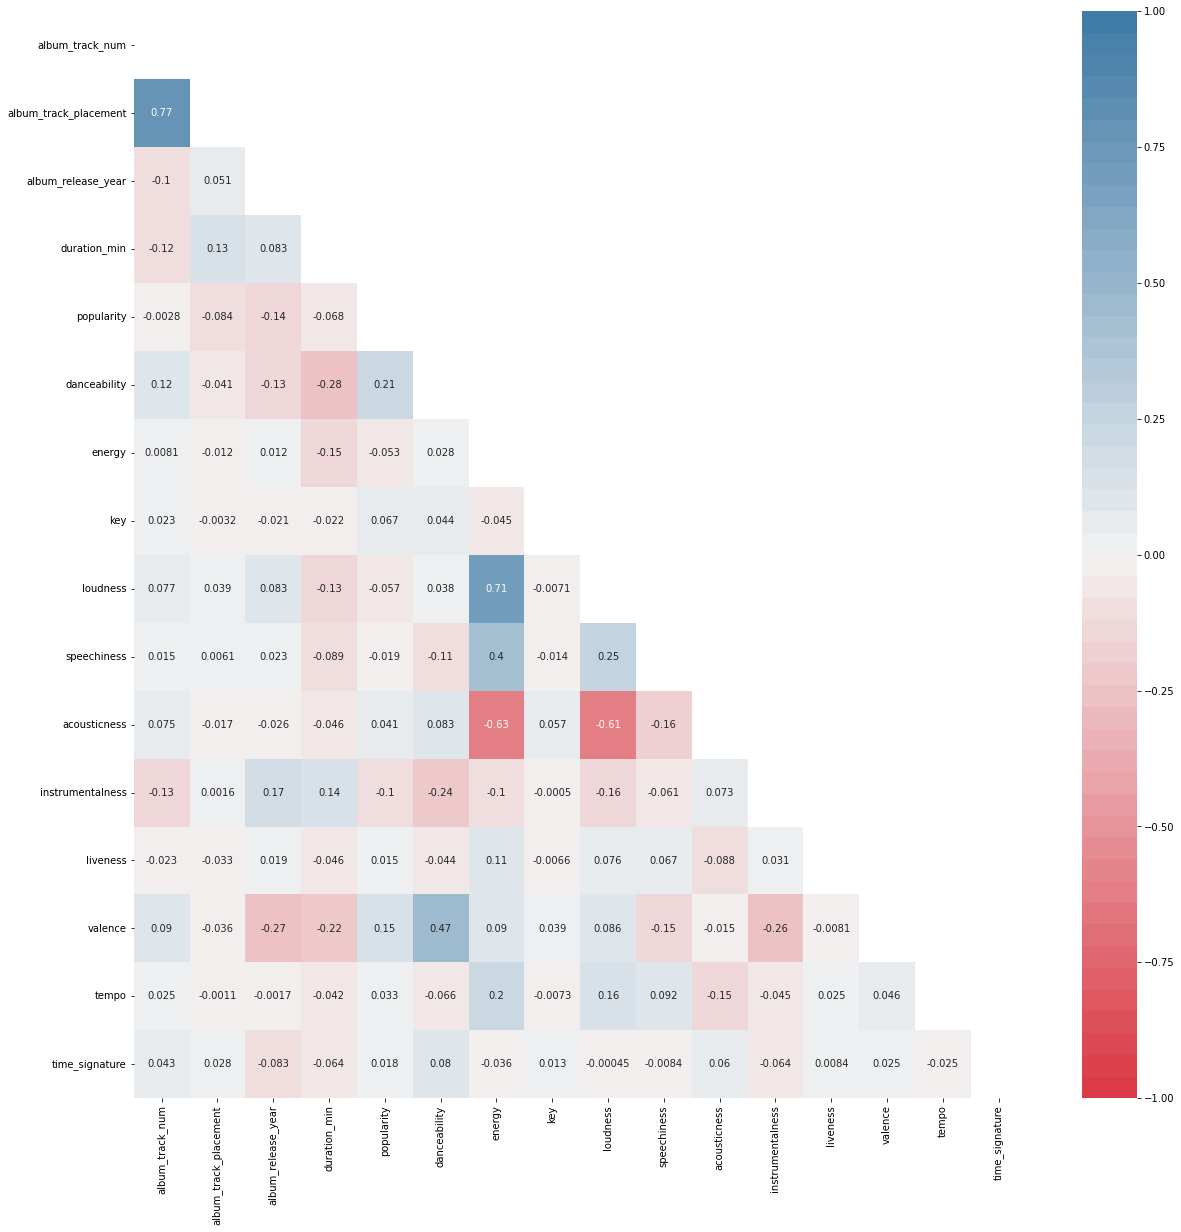

In [18]:
corr = df[numerical].corr()
mask = np.triu(corr)
cmap = sns.diverging_palette(10, 240, n=50)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask, cmap=cmap)

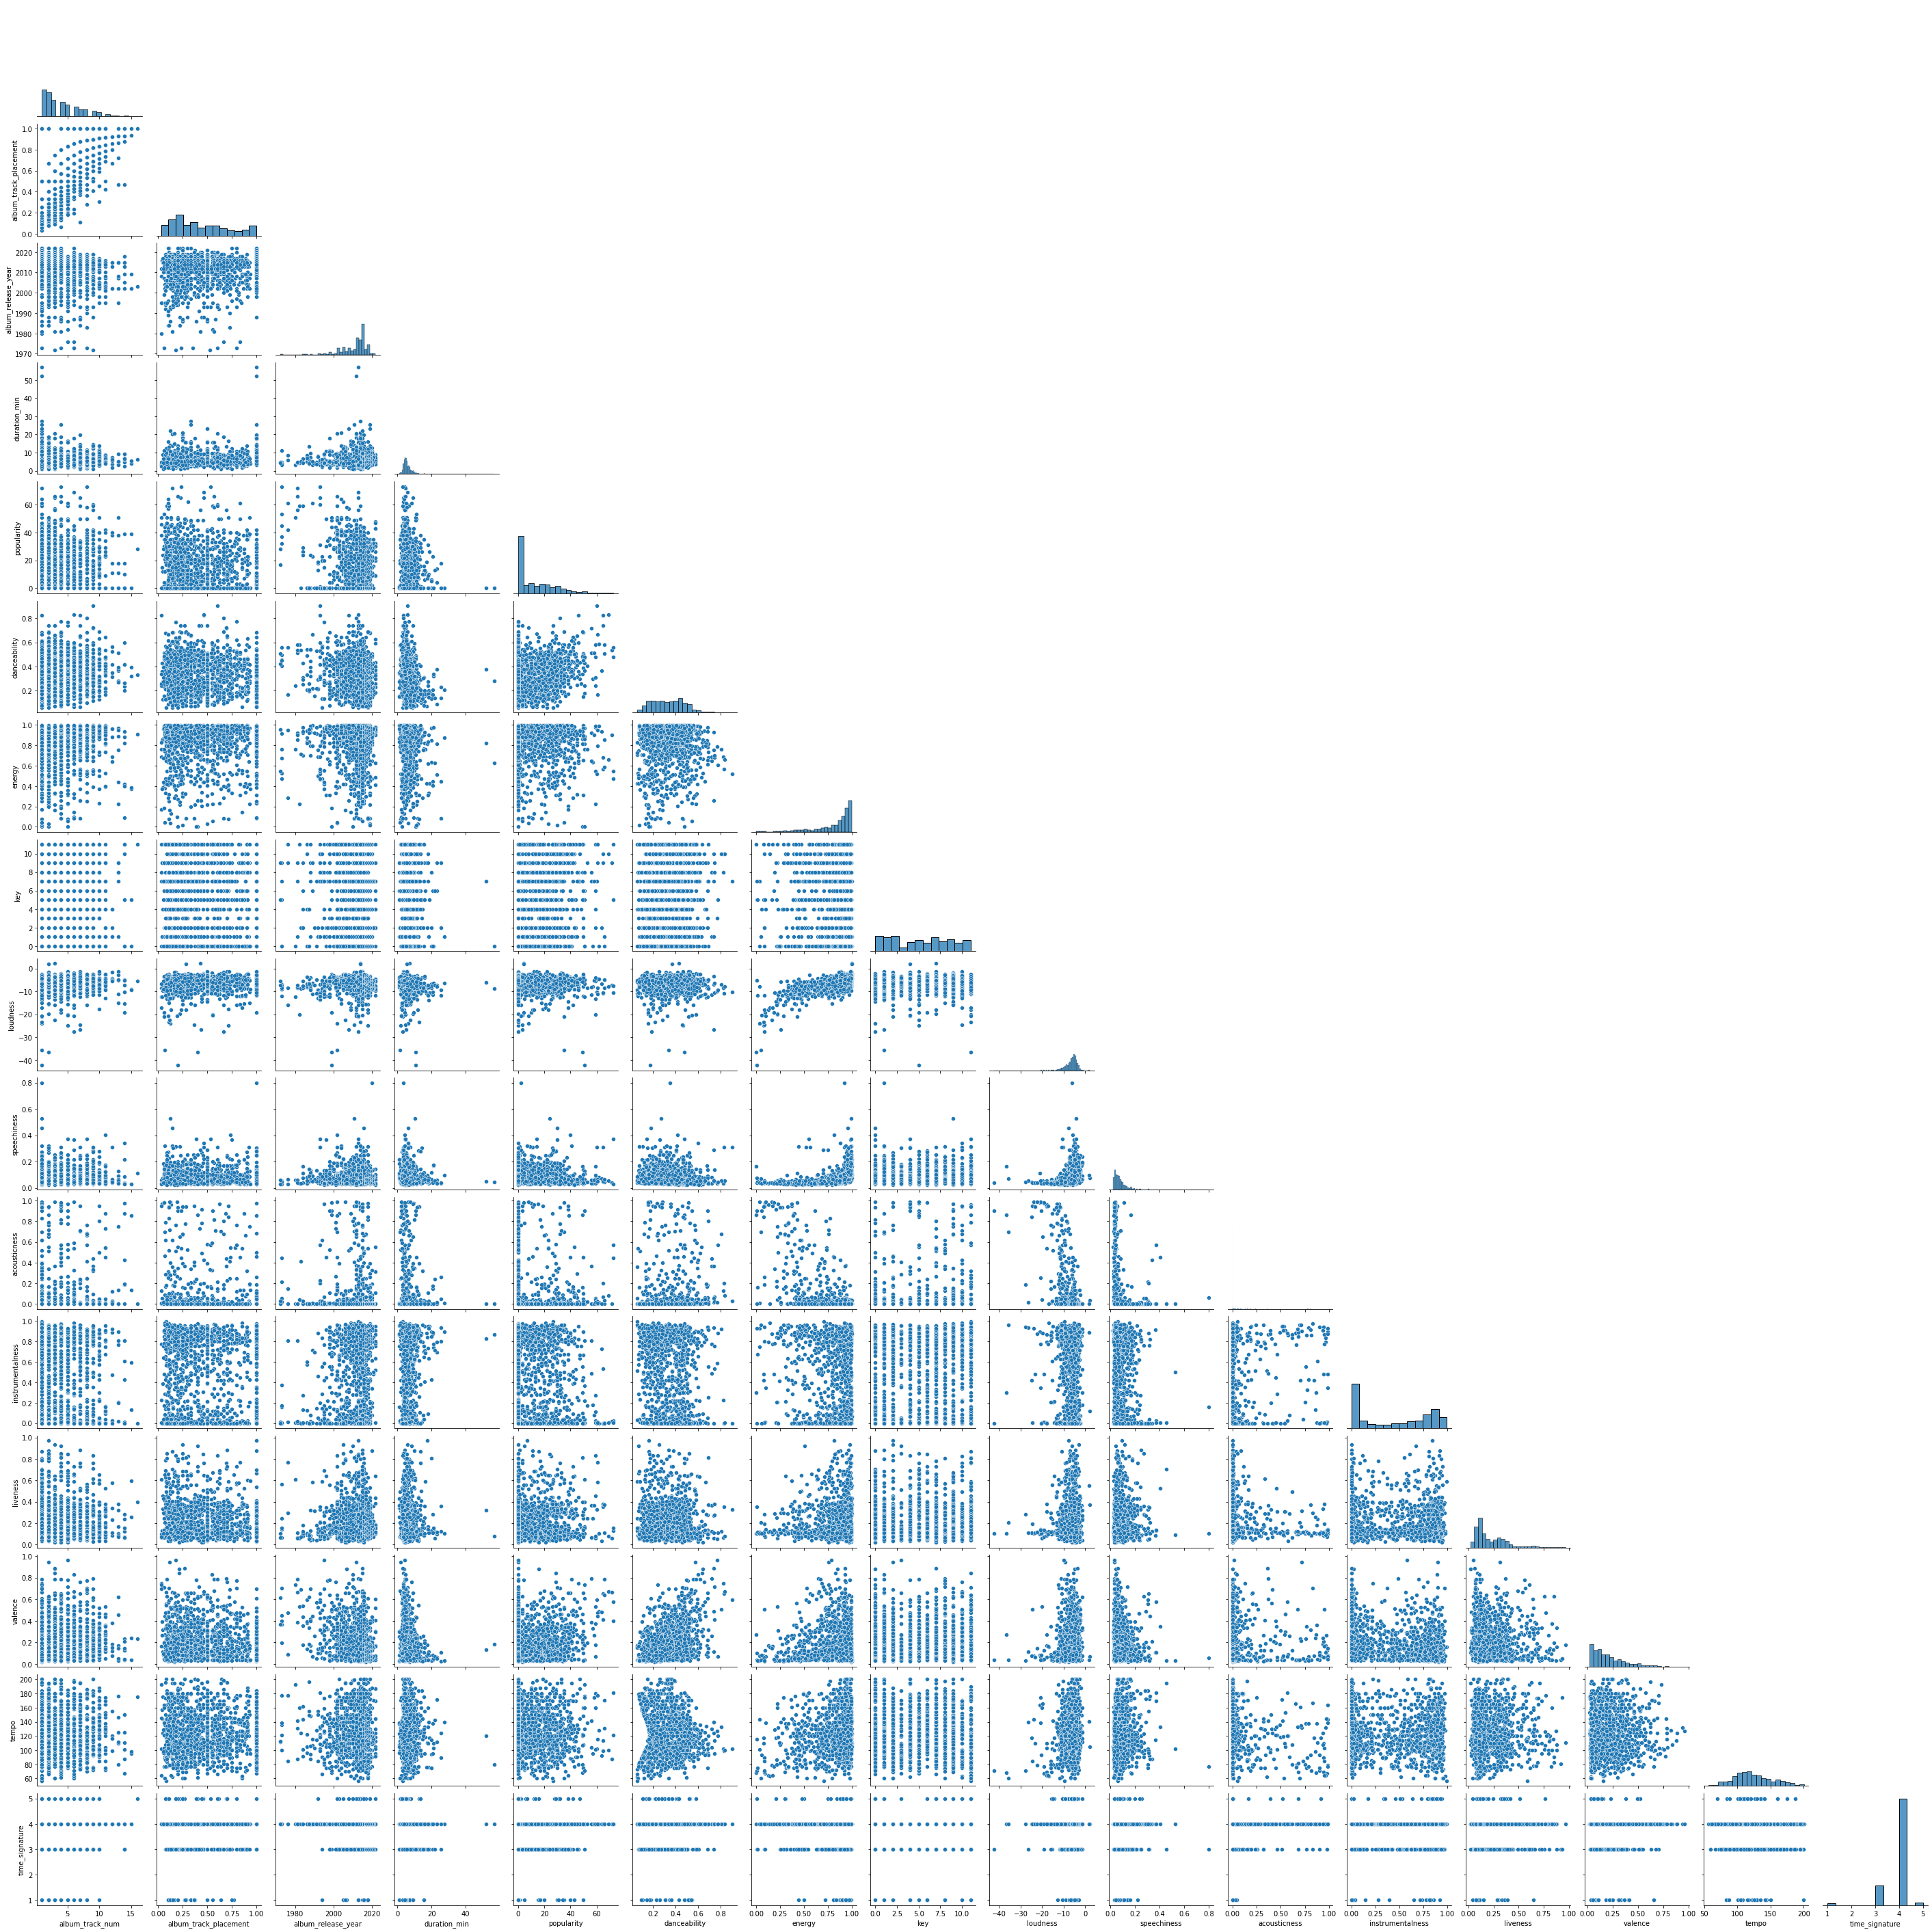

In [19]:
sns.pairplot(df[numerical], corner=True)

# Clustering
I want to see if I can cluster the data. I use K-Means clustering on the numerical features to achieve this. For some fixed number of clusters k, k-means begins by picking random points to be cluster centers, then assigning each point to the cluster with the nearest center. The centers of each cluster are computed, then points are reassigned to the cluster with the nearest center. This process of computing cluster centers and reassigning points repeats until some convergence condition is met, like the sum of squared distances within clusters falling below some level. 

For k-means, means and variances must be standardized. I use mean = 0 and std = 1.

K-means is unsupervised, meaning it does not use labeled data to train. This means that we cannot compare predictions to known values to choose the number of clusters k. Instead, I use the elbow method. For the elbow method, first you choose some range of k values to try. You run k-means for each and plot the sum of squared distances within clusters against the k values. Ideally, the plot should have what looks like an "elbow." For values of k larger than the value at the elbow, the sum of squard distances should decrease much more slowly than it increases for smaller values.

In [96]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df[numerical])

100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


TypeError: 'numpy.ndarray' object is not callable

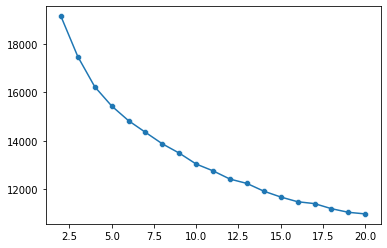

In [91]:
from sklearn.cluster import SpectralClustering
k_range = np.linspace(2, 20, num=19, dtype=int)
ssd = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)

sns.scatterplot(x=k_range, y=ssd)
sns.lineplot(x=k_range, y=ssd)
plt.show()

In [108]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_

# Analyzing Clusters

## Visualizing Clusters
The clusters can be visualized using a dimensional reduction technique, here, princiapl components analysis (PCA). Principal components analysis finds vectors pointing in directions of maximum variance in the data, each vector orthogonal to all the other vectors. These vectors are the principal components. To visualize the clusters, the data is plotted on the first two principal coordinates.

In [109]:
pca = PCA()
pca_vals = pca.fit_transform(df_scaled)

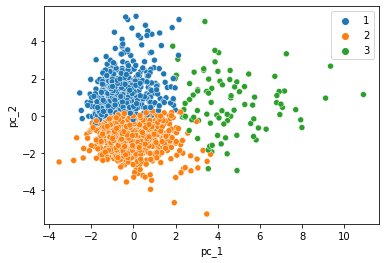

In [122]:
df_pca = pd.DataFrame(pca_vals, columns=[f'pc_{i+1}' for i in range(len(numerical))])
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=cluster_labels+1, palette='tab10')
plt.show()

We can see from the above that the clusters look nicely separated when plotted on the principal coordinates. However, the third cluster seems to have fewer members than the other two.

## Summary Statistics

In [113]:
# Add cluster labels to original dataframe
df['cluster_labels'] = cluster_labels +1

I will plot the summary statistics for each feature broken out by clusters. Do do this, first I calculate the mean and standard deviation for each feature for each cluster. I also check the number of members in each cluster.

In [123]:
df_summ_stats = df[numerical + ['cluster_labels']].groupby('cluster_labels').agg(['mean', 'std', 'count'])
df_summ_stats

album_track_num                 album_track_placement  \
                          mean       std count                  mean   
cluster_labels                                                         
1                     5.250417  3.089100   599              0.478413   
2                     3.098918  2.253195   647              0.394010   
3                     4.466667  3.709084    90              0.424691   

                               album_release_year                  \
                     std count               mean       std count   
cluster_labels                                                      
1               0.277621   599        2008.454090  8.867143   599   
2               0.269467   647        2013.063369  5.100598   647   
3               0.305772    90        2010.955556  7.974554    90   

               duration_min  ... liveness   valence                  \
                       mean  ...    count      mean       std count   
cluster_labels               ...                                      
1                  5.157308  ...      599  0.311670  0.177097   599   
2                  7.182906  ...      647  0.126774  0.086731   647   
3                  5.880207  ...       90  0.147951  0.160926    90   

                     tempo                  time_signature                  
                      mean        std count           mean       std count  
cluster_labels                                                              
1               125.216169  27.930005   599       3.899833  0.447942   599  
2               124.878526  29.497328   647       3.721793  0.614483   647  
3               106.018122  30.952821    90       3.922222  0.403016    90  

[3 rows x 48 columns]

This confirms what I determined from the PCA plot - there are much fewer members in the third cluster than the other two.

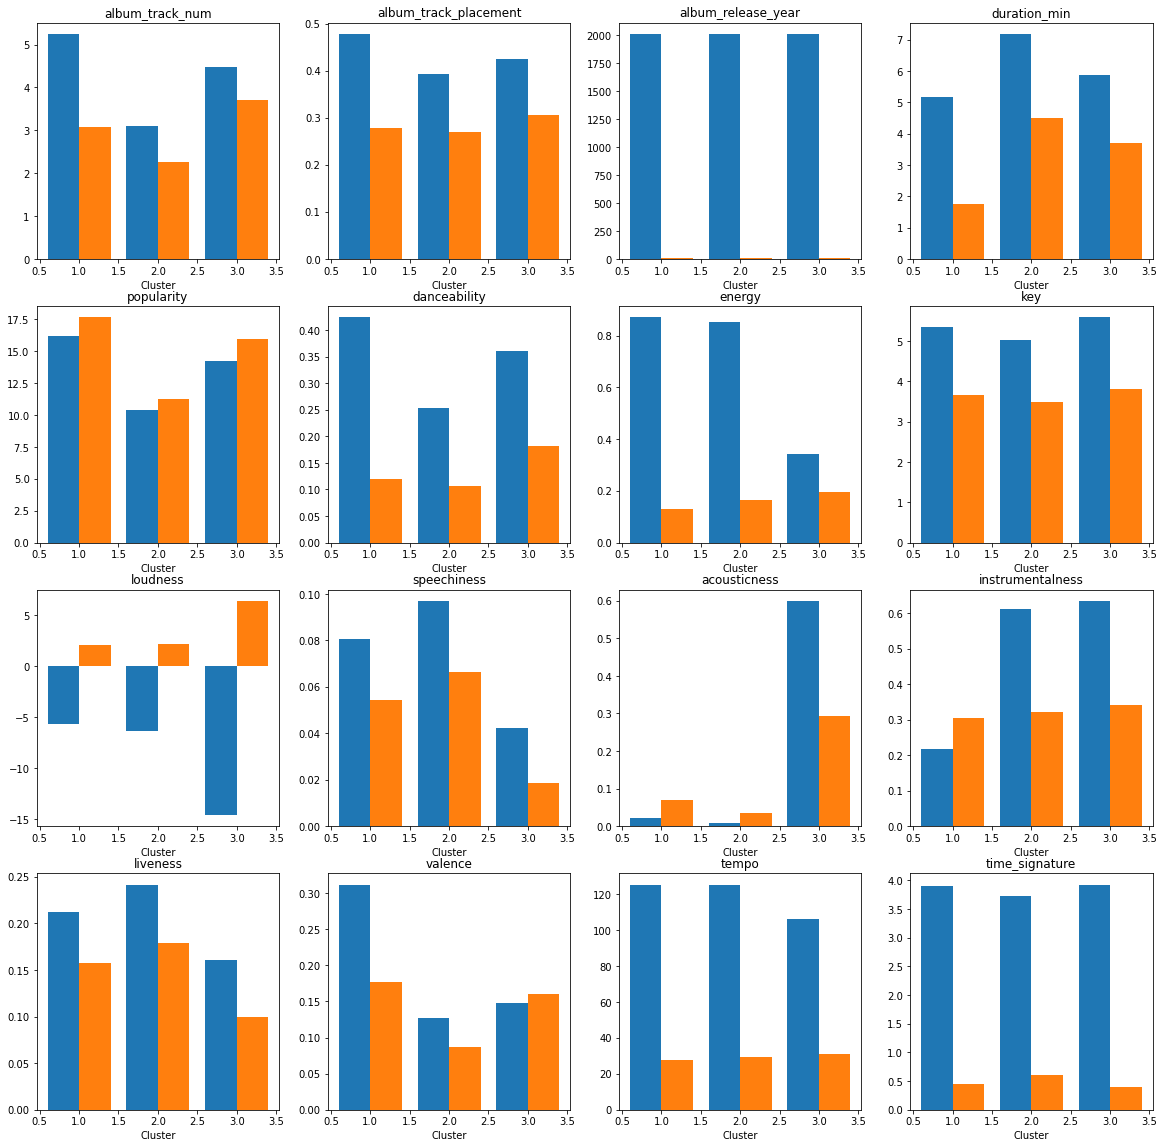

In [144]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
clusters = np.array(range(1, k+1))
for feature, ax in zip(numerical, np.ravel(axes)):
    # Plot means
    ax.bar(x=clusters - 0.2, height=df_summ_stats[feature]['mean'], width=0.4)

    # Plot standard deviations
    ax.bar(x=clusters + 0.2, height=df_summ_stats[feature]['std'], width=0.4)

    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    

To avoid cluttering up the plots with legends, note that means are the bars on the left (in blue), and standard deviations are the bars on the right (in organge).

## Variable Distributions and Relationships Within Clusters
We can now plot similar plots to those in the initial data analysis, except this time, we can break songs out by cluster assignment.

## Univariate Distributions

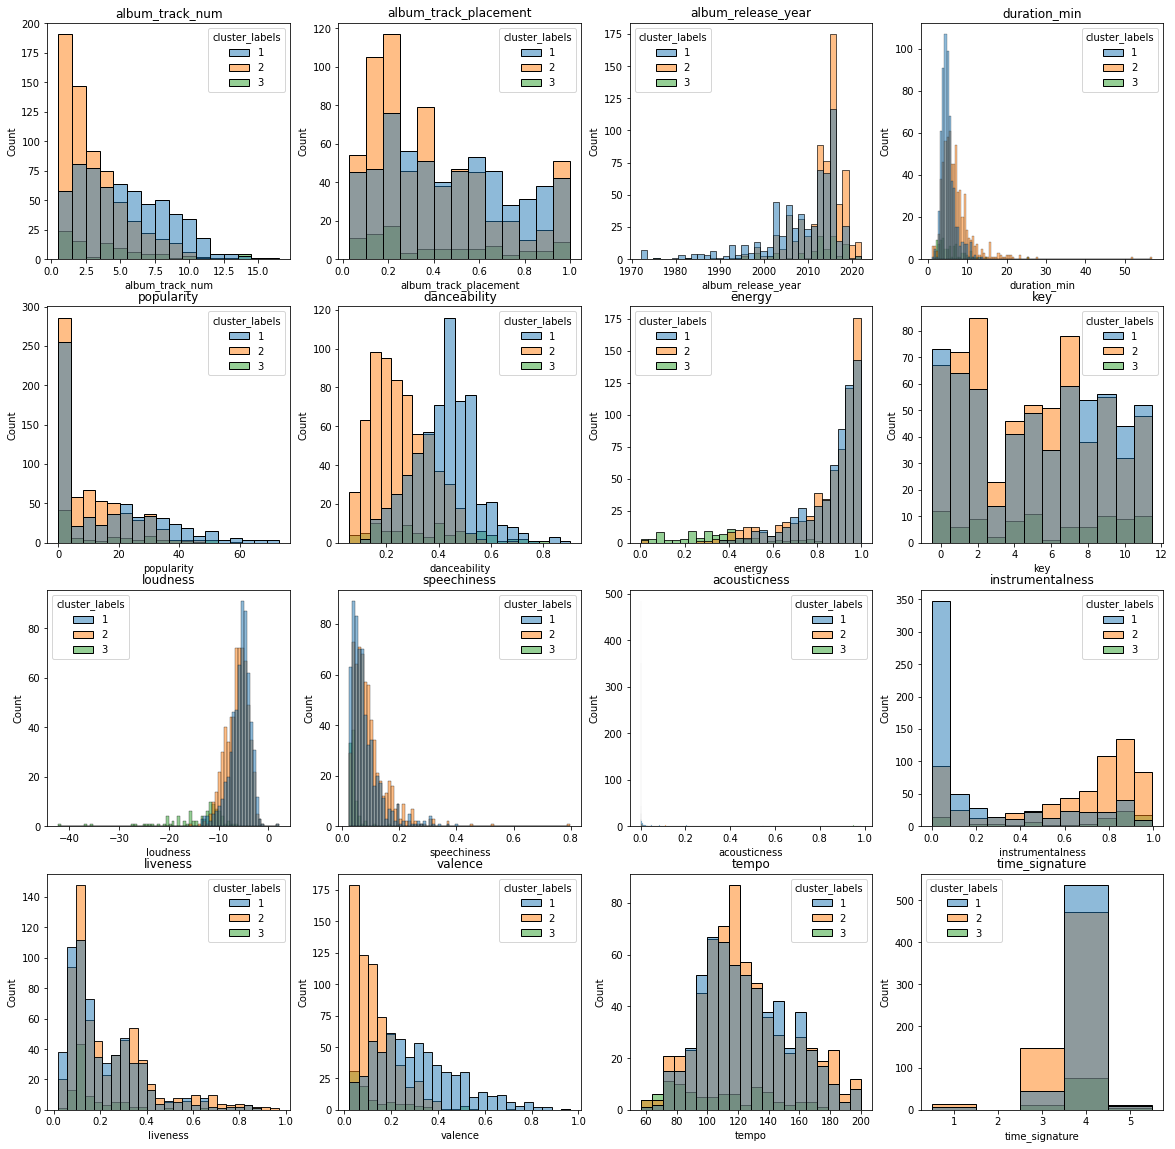

In [138]:
fig, axes = plt.subplots(4,4, figsize=(20,20))

for col, ax in zip(numerical, np.ravel(axes)):
    if col == 'album_track_num' or col == 'time_signature' or col == 'key':
        sns.histplot(data=df, x=col, hue='cluster_labels', discrete=True, ax=ax, palette='tab10')
    else:
        sns.histplot(data=df, x=col, hue='cluster_labels', ax=ax, palette='tab10')
    ax.set_title(col)

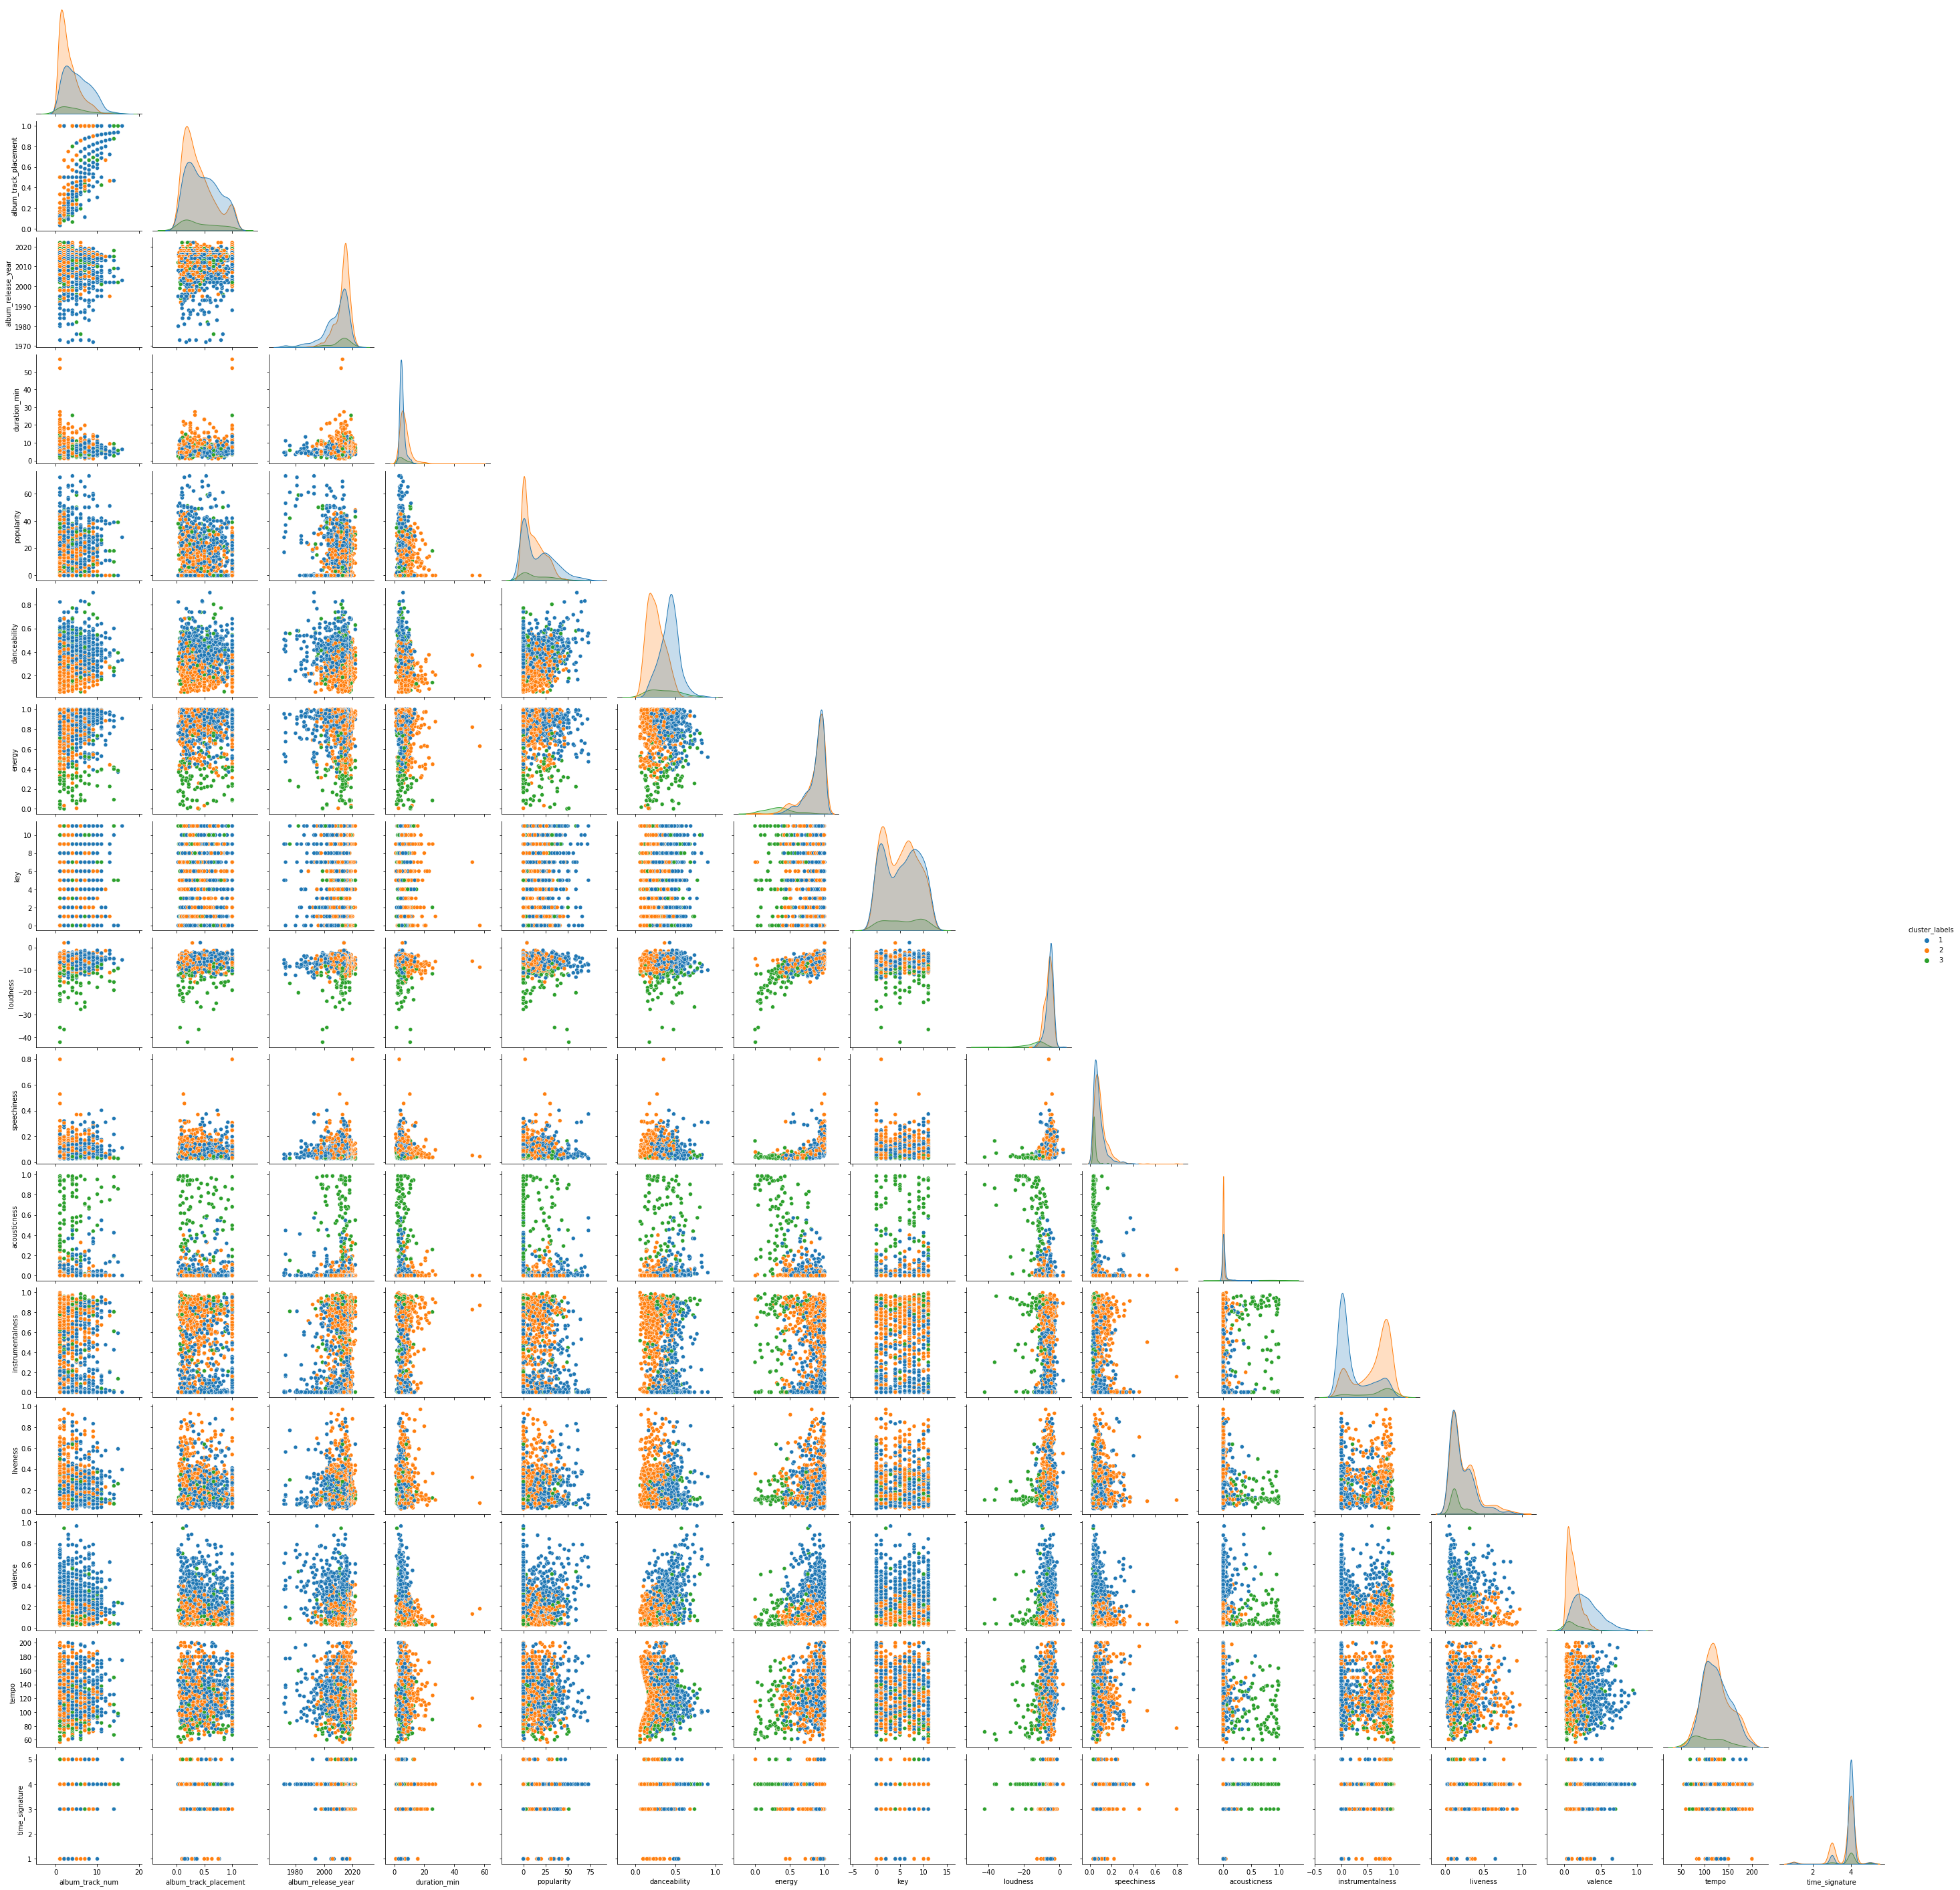

In [147]:
sns.pairplot(df[numerical + ['cluster_labels']], hue='cluster_labels', corner=True, palette='tab10')

## Examining Songs within Clusters
To figure out the degree to which the clusters are human interpretable, I print out a number of songs from each.

In [160]:
print('50 Random Songs from Cluster 1')
df[df['cluster_labels'] == 1][song_info].sample(frac=1, random_state=123).head(50)

50 Random Songs from Cluster 1


track_name  \
843                         Creeping Death (Remastered)   
206                                        Vassalplasty   
1244                                       High and Dry   
810                                              Aurora   
916                                   Charging the Void   
42                                         Veil of Maya   
974                                    Hold Your Colour   
1255                                      Vesperal Hymn   
700                                In Flagrante Delicto   
973                                        The Terminal   
1110                                        Still Alive   
242                                Röyksopp's Night Out   
695                                    Sending You Back   
178                                        Order Divine   
274       On Some Faraway Beach - 2004 Digital Remaster   
1320                             1979 - Remastered 2012   
853                                  At The Gallows End   
1312                                 The Gothic Embrace   
1162                                         Pareidolia   
725                                    For Broken Words   
1258                                The Atlantean Kodex   
1139                                  Black in the Burn   
1299                                     For The Future   
1159                                        Black Sites   
499   Wu-Tang Clan Ain't Nuthing ta F' Wit (feat. RZ...   
539                                                Sets   
423                                     Progeny of Pain   
454                                              Moskau   
901                                          Slow Light   
121                                     End of the Line   
375                       Welcame (Furyo State Of Mind)   
569                                        Megatropolis   
641                                          Beastblade   
568                               Farewell And Good Bye   
562                                             Ísafold   
1218                          Humans Are Such Easy Prey   
837                                      Into the Light   
1150                               Songs from the North   
553                                           Affection   
31                                            Aggressor   
543                If You Want Peace... Prepare For War   
786                          Where Have The Angels Gone   
825                                                Duat   
1194  Funeral For A Friend / Love Lies Bleeding - Re...   
1334                                      The Alcoholic   
940                                             Indians   
22                                       Þú Fórst Hvurt   
899                                       Under The Oak   
1112                                      For the Horde   
686                            Power of the Dragonflame   

                     artist                                         album_name  
843               Metallica               Ride The Lightning (Deluxe Remaster)  
206          Dawn Of Azazel                              The Tides of Damocles  
1244              Radiohead                    The Bends (Collector's Edition)  
810           Ghost Brigade                             Iv: One with the Storm  
916                  Vektor                                     Terminal Redux  
42                    Cynic                                              Focus  
974                Pendulum                                   Hold Your Colour  
1255        Atlantean Kodex                                   The Golden Bough  
700          Anaal Nathrakh                               The Whole of the Law  
973                Pendulum                                   Hold Your Colour  
1110        Nocturnal Rites                                     Grand Illusion  
242                Röyksopp                                    

In [159]:
print('50 Random Songs from Cluster 2')
df[df['cluster_labels'] == 2][song_info].sample(frac=1, random_state=123).head(50)

50 Random Songs from Cluster 2


track_name  \
129                         Lorem Ipsum (Arctic Anthem)   
1318                                      Redcap Part 3   
71                                    Citadel Of Dreams   
963                                           Lumikuuro   
925                                       Chaos Bringer   
744                                              Raidho   
866                                               Satan   
556                                Creation Level Event   
234                                 Blessed Entwinement   
328                                  Gates to Blashyrkh   
380                                Crones To The Flames   
460                                     Blooming Blades   
852                                            Returner   
231                                        Ethica Odini   
412                               A Lonely Place to Die   
1087                                                 At   
120                                               Sepal   
230                                            Ironlung   
1015                                   Malek al-Inkitar   
626                                      Roots to Sever   
644                                  Un Feu Indomptable   
671                   Carnal Ways To Recreate The Heart   
776                                        Heavy Riders   
663   Sanctuary: Light & Grief - Act Iii: Exiled to ...   
1155                                 Birth of Ignorance   
83                                                 Aska   
512                                          From Birth   
223                                    Twilight Odyssey   
267                               Breath and Levitation   
614                                   The Grinning Mist   
923                                  Slave Annihilation   
11                                             Mountain   
62                                             Collapse   
179                                  In Service of Time   
125                                     Angelus Noctium   
348                                               Opale   
1170                                           Volatile   
249                                            Lágnætti   
905                               Blessed He With Boils   
1233                                Back Where I Belong   
279                                             Bridges   
804                                      Fiddle of Time   
1023                                   Nightmare's Reef   
288                                           Outermost   
927                              The Art of Destruction   
994                                     Deus Ex Machina   
87                                  The Bray Road Beast   
1012                            From a Frozen Wasteland   
119                                       Unending Grey   
272                             Within the Dead Horizon   

                       artist                        album_name  
129              Anamanaguchi                             [USA]  
1318                   Ramleh                 Hole in the Heart  
71          Garden Of Shadows                       Oracle Moon  
963                     KAUAN                         Muistumia  
925       Gospel of the Horns                    A Call to Arms  
744                  Enslaved               Axioma Ethica Odini  
866                Bongripper            Satan Worshipping Doom  
556                   Mechina            As Embers Turn to Dust  
234                    Krypts              Unending Degradation  
328                  Immortal               Northern Chaos Gods  
380         Ancient Ascendant                 Echoes And Cinder  
460                  CHTHONIC             Mirror of Retribution  
852                   Liturgy                       Aesthethica  
231                  Enslaved               Axioma Ethica Odini  
412             Marianas Rest                

In [157]:
print('50 Random Songs from Cluster 3')
df[df['cluster_labels'] == 3][song_info].sample(frac=1, random_state=123).head(50)

50 Random Songs from Cluster 3


track_name  \
1052                                             Origin   
1108              Ouverture: I. Grave - Allegro - Grave   
347                                       Mono No Aware   
902                                        Ghost Return   
1273                                           Fragment   
78                                     dream is destiny   
434                                           Reverence   
1225                                                 IV   
1221                                               Open   
1105  Symphony No. 9 in E Minor "From The New World"...   
490                                       Mono No Aware   
819                                 Daughter of the Sea   
158   Spiegel im Spiegel - Version for Violin and Piano   
1057                                    Docking the Pod   
1247                                           Twinkler   
507                                             Celeste   
346                                        Death Rattle   
1179                                   Arising Armament   
818                                Just Shy of Survival   
597                                               Other   
1060                                              Alpha   
293                                            Augustus   
1058                                   Topical Solution   
952               Miserere in C Minor Psalm 50, ZWV. 57   
1292                                    Binker Part Two   
296         Spiegel im Spiegel, für Violine und Klavier   
1226                                                III   
176                                        Kingdoms (G)   
285                            An Empty Vessel To Flood   
1016                                           Homeland   
262                                           Keyed out   
573                                             Confess   
1325                          Crawling on Bruised Knees   
930   Missa omnium sanctorum, ZWV 21: Gloria. Quonia...   
226                                                Keep   
284                        Enlightenment (Hold Onto Me)   
1241                                       Pyramid Song   
558                                            Monument   
53                                  To Bid You Farewell   
1238                               Life in a Glasshouse   
1039                    A Long Day's Journey into Night   
1252                                 Test Pattern #0111   
255                                               Novae   
1114         Solomon HWV 67 / Act 1: "With pious heart"   
259                                    Music of the Air   
334                                     Let Them See Us   
648                         On the Coldest Winter Night   
152                                The alley of burdens   
394                                               Zebra   
632                              Balnaa-Kheil the Bleak   

                      artist  \
1052        Keep Of Kalessin   
1108      Jan Dismas Zelenka   
347             Agent Fresco   
902                     Moby   
1273                Emptyset   
78             No Clear Mind   
434          Countless Skies   
1225                   KAUAN   
1221              Com Truise   
1105          Antonín Dvořák   
490             Agent Fresco   
819          House of Wolves   
158                Arvo Pärt   
1057                  Duster   
1247                Baroness   
507            No Clear Mind   
346             Agent Fresco   
1179                CHTHONIC   
818          House of Wolves   
597            S U R V I V E   
1060                Vangelis   
293                  Khôrada   
1058                  Duster   
952       Jan Dismas Zelenka   
1292              LAKE R▲DIO   
296                Arvo Pärt   
1226                   KAUAN   
176                sunn O)))   
285                Ben Frost   
1016              Sarpanitum   
262               Tim Hecker   
573        

I find this cluster particularly impressive. It's pretty clearly identified slower, quieter, dronier tracks with a large portion of the songs listed above being non-metal tracks.

### Artists and Albums Unique to One Cluster
Useful to interpreting the clusters will be to find the artists and albums that are in one cluster but not the other cluster. I find these and print them out. Rather than printing all of the values unique to a cluster, I print the minimum of fifty and the total number of artists/albums in the cluster to save space. However, I did personally examine all of the values unique to each cluster.

#### Artists only Found Within one Cluster

In [190]:
def unique_to_cluster(feature):
    unique_labels  = df['cluster_labels'].unique()
    unique_feature_vals = {cluster:[] for cluster in unique_labels}

    for cluster in unique_labels:
        other_clusters = [i for i in unique_labels if i != cluster]
        unique_values = df[df['cluster_labels'] == cluster][feature].unique()

        # Find unique values in other clusters
        other_cluster_values = []
        for i in other_clusters:
            other_cluster_values.extend(df[df['cluster_labels'] == i][feature].unique())

        # Find values unique to cluster under consideration
        for value in unique_values:
            if value not in other_cluster_values:
                unique_feature_vals[cluster].append(value)
    return unique_feature_vals

no_overlap_artists = unique_to_cluster('artist')
for cluster in no_overlap_artists.keys():
    num_unique_to_cluster = len(no_overlap_artists[cluster])
    print(f'The following {min(50, len(no_overlap_artists[cluster]))} artists are only in cluster {cluster}:')
    print(', '.join(no_overlap_artists[cluster][:min(50, len(no_overlap_artists[cluster]))]))

The following 50 artists are only in cluster 2:
Nite, Artificial Brain, EABS, Sulphur Aeon, Thrawsunblat, Latitudes, Cities of the Plain, Generation Of Vipers, Tempel, Inhuman Condition, Pan-Amerikan Native Front, Blackbraid, Mithras, Vanum, Barishi, Be'lakor, Mesarthim, Mistur, Internal Bleeding, Garden Of Shadows, Cloudkicker, Heretoir, The Besnard Lakes, Der Weg einer Freiheit, Wreck and Reference, Dumal, SLIFT, Nocturnal Graves, Haunted Shores, Fluisteraars, Eneferens, Hope Drone, ORM, Sarastus, Gatekeeper, Imha Tarikat, Pestilence, Vukari, Consummation, Chthe'ilist, False, Monolithe, Void Omnia, Solar Temple, Windswept, Krater, Mizmor, Nullingroots, Djevel, Noctem
The following 50 artists are only in cluster 1:
Death Angel, Cynic, Ancient Bards, Voyager, Witchcraft, DJ Shadow, Children Of Bodom, Cannibal Ox, Car Bomb, Cory Henry, Brian Eno, CHVRCHES, Sleigh Bells, Hällas, Home, Avantasia, Earth Ship, Carcass, iamamiwhoami, Ajattara, Nocturnus, Forest Of Fog, Procession, Arjen Anth

#### Artists only Found Within one Cluster

In [186]:
no_overlap_album = unique_to_cluster('album_name')
for cluster in no_overlap_artists.keys():
    num_unique_to_cluster = len(no_overlap_album[cluster])
    print(f'The following {min(50, len(no_overlap_artists[cluster]))} albums are only in cluster {cluster}:')
    print(', '.join(no_overlap_album[cluster][:min(50, len(no_overlap_artists[cluster]))]))

The following 50 albums are only in cluster 2:
Voices of the Kronian Moon, Artificial Brain, Discipline of Sun Ra, The Scythe of Cosmic Chaos, Metachthonia, Old Sunlight, Where Our Homes Used to Be, Coffin Wisdom, On the Steps of the Temple, Fearsick, UNDER THE FORCE OF COURAGE, Little Turtle's War, Barefoot Ghost Dance on Blood Soaked Soil, Across The Dark, On Strange Loops, Blood from the Lion's Mouth, Viperous, Infrared Horizon, When A Shadow Is Forced Into The Light, Coherence, Argent Moon - EP, The Density Parameter, The Moon Lit Our Path, In Memoriam, Overthrow Creation, Oracle Moon, Winter's Gate, The Conjurer, Beacons, The Circle, Móðurástin, The Sanguinary Impetus, A Coliseum Complex Museum, Reflections of a Floating World, Renihilation, Sagor, Stellar, Finisterre, Black Cassette, The Lesser God, UMMON, Propelled Into Sacrilege, …from the Bloodline of Cain, Please Don't Walk on the Mass Graves, Viscera, Vlek, The Bleakness of Our Constant, Cloak of Ash, Sepal, Ir
The following

## Interpretation
I believe that the clusters are human interpretable.

The first cluster consists of more melodic, upbeat music. Here you have power metal and melodic death metal, both generally upbeat or at least melodic genres, along with catchier, non-metal artists like Daft Punk and iamamiwhoami. 

The second cluster consists of the heavier, darker, or more aggressive music. In this cluster, you have the more brutal death metal, the more aggresive black metal and the darker doom. The category is not perfect, as it also contains bands like The Besnard Lakes, a shoegaze band that makes fairly bright music.

The third category consists of less heavy or atmospheric music. Here you have classical, ambient, and acoustic music.

# Conclusion
This analysis more or less confirmed my suspicion. Most of the music I listen to is, in fact, corny, aggressive, and loud. However, some of the music I listen to is a bit more atmospheric.